# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

<b> Данные геологоразведки трёх регионов находятся в файлах:</b>
- /datasets/geo_data_0.csv. Данные по 1 региону
- /datasets/geo_data_1.csv. Данные по 2 региону
- /datasets/geo_data_2.csv. Данные по 3 региону
- **id** — уникальный идентификатор скважины;
- **f0**, **f1**, **f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

# Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [5]:
#Импортируем библиотеки

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error


In [6]:
#Изучение данных
#Для этого создадим функцию
#Так как у нас даны три датасета, то основные действия для выгрузки и первичного изучения данных будут одинаковые

def reading_data(file_path):
    data = pd.read_csv(file_path)
    print('Количество явных дубликатов:', sum(data.duplicated()))
    display(data.head())
    print('')
    display(data.info())
    print(data.describe())
    print(data.corr())
    return data

In [7]:
geo0_data = reading_data('geo_data_0.csv')

Количество явных дубликатов: 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


/var/folders/wd/gl0hh07s1f73kj7kynty4z6r0000gn/T/ipykernel_29901/1147411488.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr())


In [8]:
geo1_data = reading_data('geo_data_1.csv')

Количество явных дубликатов: 0


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


/var/folders/wd/gl0hh07s1f73kj7kynty4z6r0000gn/T/ipykernel_29901/1147411488.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr())


In [9]:
geo2_data = reading_data('geo_data_2.csv')

Количество явных дубликатов: 0


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


/var/folders/wd/gl0hh07s1f73kj7kynty4z6r0000gn/T/ipykernel_29901/1147411488.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr())


- Пропуски отсутсвуют

- Дубликаты отсутсвуют 

- Данные **f0**, **f1**, **f1** примерно одного порядка - масштабироание не требуется

In [10]:
#Выделим признаки и целевой признак

features_columns = ['f0','f1', 'f2']
targets_columns = ['product']

#Признаки для 1 региона
features_geo0 = geo0_data[features_columns]
#Признаки для 2 региона
features_geo1 = geo1_data[features_columns]
#Признаки для 3 региона
features_geo2 = geo2_data[features_columns]

#Целевой признак для 1 региона
targets_geo0 = geo0_data[targets_columns]
#Целевой признак для 2 региона
targets_geo1 = geo1_data[targets_columns]
#Целевой признак для 3 региона
targets_geo2 = geo2_data[targets_columns]
    

## Обучение и проверка модели

In [11]:
#Аналогично прошлому пункту
#Создадим функцию, которая будет делить выборки, обучать модель лин.регрессии (по заданию) и вычислять ср. кв. ошибку
def geo_model_fit(features, targets):
   
    features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets, test_size=0.25, random_state=12345)
    print('Количество строк обучающей выборки:', features_train.shape[0])
    print('Количество строк валидационной выборки:', features_valid.shape[0])
    
    model = LinearRegression()
    model.fit(features_train, targets_train)
    predict = model.predict(features_valid)

    predict_mean = predict.mean()
    rmse = mean_squared_error(targets_valid, predict)**.5

    print('Cредний предсказанный объем сырья: {:.3f}'.format(predict_mean))
    print('RMSE модели: {:.3f}'.format(rmse))
    
    print('___________________________________________________________________ \n')
    
    
    return targets_valid, predict

In [12]:
#Прогоним функцию для каждого региона

geo0_targets_valid, geo0_predict = geo_model_fit(features_geo0, targets_geo0)
geo1_targets_valid, geo1_predict = geo_model_fit(features_geo1, targets_geo1)
geo2_targets_valid, geo2_predict = geo_model_fit(features_geo2, targets_geo2)

Количество строк обучающей выборки: 75000
Количество строк валидационной выборки: 25000
Cредний предсказанный объем сырья: 92.593
RMSE модели: 37.579
___________________________________________________________________ 

Количество строк обучающей выборки: 75000
Количество строк валидационной выборки: 25000
Cредний предсказанный объем сырья: 68.729
RMSE модели: 0.893
___________________________________________________________________ 

Количество строк обучающей выборки: 75000
Количество строк валидационной выборки: 25000
Cредний предсказанный объем сырья: 94.965
RMSE модели: 40.030
___________________________________________________________________ 



- минимальный RMSE - для 2 региона, то есть модель, обученная по данным, наиболее точно предсказывает объем в скважине

- для 1 и 3 региона RMSE намного больше, при этом средние значения предсказанного объема сырья имеет высокие значения, в отличии от 2 региона 

## Подготовка к расчёту прибыли

In [13]:
#Посчитаем минимальный средний объем в скважине, достаточный для разработки
caps = 10**10
best_wells, all_wells = 200, 500
oil_bar_price = 450*1000

min_product = caps / (best_wells * oil_bar_price)
print('Минимальный объём продукта с одной скважины для безубыточной разработки: {:.2f}'.format(min_product))

Минимальный объём продукта с одной скважины для безубыточной разработки: 111.11


Минимальный объем безубыточной скважины больше среднего предсказанного запаса в каждом регионе, рассчитанного ранее.

## Расчёт прибыли и рисков 

Перед расчетом переведем наши ранее полученные целевые признаки и предсказания к одному типу данных (например Series)

In [14]:
geo0_targets_valid = pd.Series(geo0_targets_valid['product'].reset_index(drop = True))
geo1_targets_valid = pd.Series(geo1_targets_valid['product'].reset_index(drop = True))
geo2_targets_valid = pd.Series(geo2_targets_valid['product'].reset_index(drop = True))

geo0_predict = pd.Series(*geo0_predict.reshape(1,-1))
geo1_predict = pd.Series(*geo1_predict.reshape(1,-1))
geo2_predict = pd.Series(*geo2_predict.reshape(1,-1))

In [15]:
#Функция расчета прибыли 
state = np.random.RandomState(12345)

def revenue_calculation(target, predicts,show = True):
    sample_preds = predicts.sample(n = all_wells, 
                                   replace = True, 
                                   random_state=state)
    best_preds = sample_preds.sort_values(ascending=False)[:best_wells]
    best_targets = target[best_preds.index]  
    revenue = sum(best_targets) * oil_bar_price  - caps
    if show:
        print(f'Средний запас одной из лучших скважин региона: {"%.3f" % best_targets.mean()} млн. бар.')
        print(f'Выручка при разработке скважин этого региона: {"%.3f" % (revenue/10**6)} млн. руб')

    return revenue

In [16]:
revenue_calculation(geo0_targets_valid, geo0_predict)

Средний запас одной из лучших скважин региона: 117.838 млн. бар.
Выручка при разработке скважин этого региона: 605.464 млн. руб


605464074.5690022

In [17]:
revenue_calculation(geo1_targets_valid, geo1_predict)

Средний запас одной из лучших скважин региона: 114.826 млн. бар.
Выручка при разработке скважин этого региона: 334.316 млн. руб


334315678.3243828

In [18]:
revenue_calculation(geo2_targets_valid, geo2_predict)

Средний запас одной из лучших скважин региона: 118.069 млн. бар.
Выручка при разработке скважин этого региона: 626.176 млн. руб


626175561.5691586

Функция расчета прибыли работает исправно!

In [19]:
#Функция для подсчета риска убытков

def risk_calculation(target, predicts):
    
    bootstrap_samples = 1000
    incomes = []
    state = np.random.RandomState(12345)
    for i in range(bootstrap_samples):
        revenue = revenue_calculation(target, predicts, show = False)
        incomes.append(revenue / 10**6)
 
    incomes = pd.Series(incomes)
    plt.suptitle('Гистограмма распределения прибыли в регионе')
    incomes.hist()
    plt.ylabel('Количество скважин')
    plt.xlabel('Выручка')
    
    
    print(f'Среднее значение выручки {"%.3f" % (incomes.mean())} млн. руб.')
    confidence_interval_lower = incomes.quantile(.025)
    confidence_interval_upper = incomes.quantile(1 - 0.025)
    print(f'Границы доверительного интервала {"%.3f" % (confidence_interval_lower)} млн. руб. : {"%.3f" % (confidence_interval_upper)} млн. руб.')
    
    loss_count = 0
    for i in incomes :
        if i < 0 :
            loss_count += 1
    print(f'Риск убытков {"%.2f" % (loss_count / bootstrap_samples * 100)} %')
    

Среднее значение выручки 395.259 млн. руб.
Границы доверительного интервала -111.216 млн. руб. : 909.767 млн. руб.
Риск убытков 7.00 %


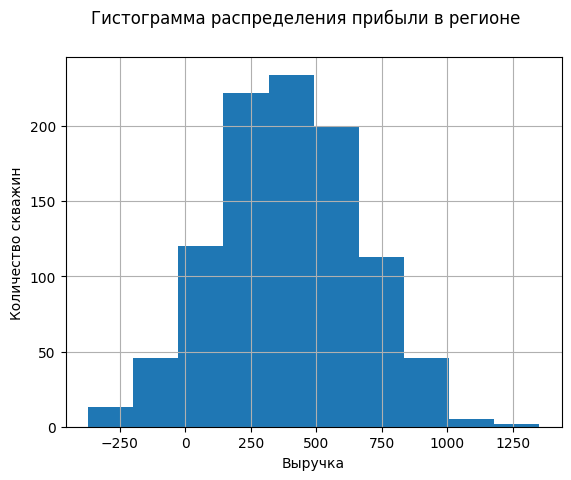

In [20]:
#Для региона 1
risk_calculation(geo0_targets_valid, geo0_predict)

Среднее значение выручки 462.190 млн. руб.
Границы доверительного интервала 78.051 млн. руб. : 862.952 млн. руб.
Риск убытков 0.70 %


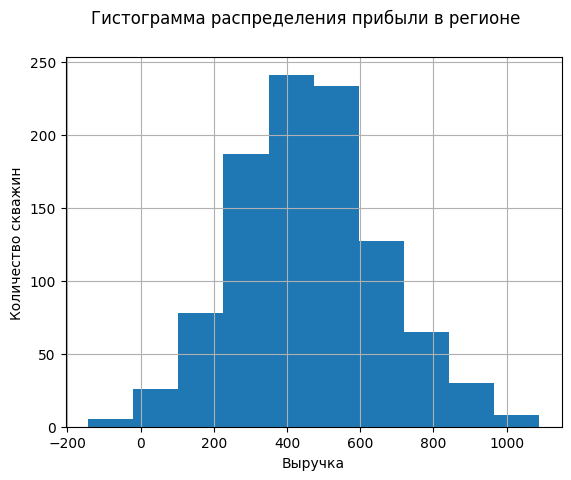

In [21]:
risk_calculation(geo1_targets_valid, geo1_predict)

Среднее значение выручки 392.446 млн. руб.
Границы доверительного интервала -112.228 млн. руб. : 934.563 млн. руб.
Риск убытков 6.50 %


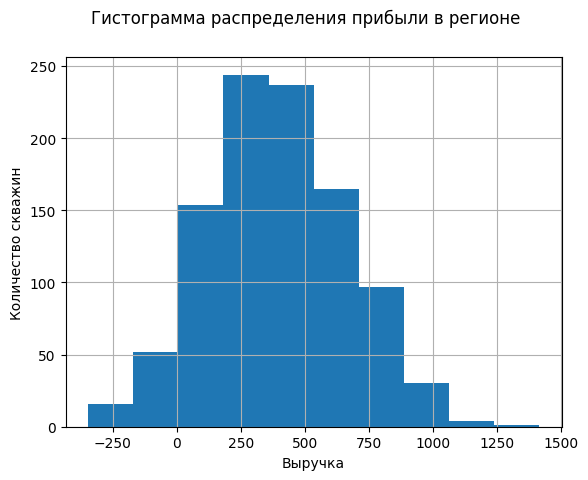

In [22]:
risk_calculation(geo2_targets_valid, geo2_predict)

## Выводы

- Согласно полученным данным, наиболее перспективной является разработка месторождений **во 2 регионе (geo1)**.

- Модель линейной регрессии показала для этого региона предсказания объема **с наименьшим RMSE (0,9)**.

- Помимо этого расчет среднего значения выручки (из 1000 случайных выборок) показал наибольшее значение при наименьшем значении риска убытков относительно остальных регионов **(448,6 млн руб при 1,8 %)**, что удовлетворяет условиям задачи

P.S. результаты могут отличаться, так как счетчик рандомных значений может сгенерировать другие выборки. На результат выбора региона это не повлияет